> ## Utils

In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
base_path = "./Images/{}"

In [3]:
def read_image(path, cvtcolor="RGB", cvtfloat=False):
    if cvtcolor == "RGB":
        if cvtfloat:
            return cv2.cvtColor(cv2.imread(base_path.format(path)), cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        return cv2.cvtColor(cv2.imread(base_path.format(path)), cv2.COLOR_BGR2RGB)
    elif cvtcolor == "GRAY":
        if cvtfloat:
            return cv2.cvtColor(cv2.imread(base_path.format(path)), cv2.COLOR_BGR2GRAY).astype(np.float32)/255.0
        return cv2.cvtColor(cv2.imread(base_path.format(path)), cv2.COLOR_BGR2GRAY)

def write_image(image, path):
    if not os.path.exists(path):
        os.mkdir(path)
    cv2.imwrite(path, image)

def show_image(image, cmap=None, title=None):
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

In [4]:
def conv2D(image: np.ndarray, filter_kernel: np.ndarray, vectorized = True) -> np.ndarray:
    height, width = image.shape[0], image.shape[1]
    k = filter_kernel.shape[0]
    pad_size = k // 2
    
    # Pads image with the edge values of array.
    image_tmp = np.pad(image, pad_size, mode="edge")

    # Initialize an empty destination image
    dst = np.zeros((height, width))

    if not vectorized:
        # Perform convolution using simple nested loops
        for i in range(height):
            for j in range(width):
                roi = image_tmp[i:i+k, j:j+k]
                dst[i, j] = np.sum(roi * filter_kernel)
    else:
        # Perform convolution using vectorization - Rather than looping over each pixel, we can loop over kernel values and multiply it with the image patch which could come from any part of the image, and add.
        for i in range(-pad_size, pad_size + 1):
            for j in range(-pad_size, pad_size + 1):
                dst += image_tmp[pad_size+i : pad_size+i+height, pad_size+j : pad_size+j+width] * filter_kernel[i+pad_size, j+pad_size]

    return dst

In [5]:
def meanFilter(image: np.ndarray, kernel_size: int, timing: bool = False, vectorized: bool = True) -> np.ndarray:
    assert kernel_size >= 1
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size * kernel_size)
    
    start = time.time()
    filtered_image = conv2D(image, kernel, vectorized=vectorized)
    end = time.time()
    if timing:
        return filtered_image, end - start
    
    return filtered_image

In [6]:
def speedyConv(image, half_kernel):
    height, width = image.shape[0], image.shape[1]
    
    integral_img = np.cumsum(np.cumsum(image, axis=0), axis=1)
    filtered_image = np.zeros_like(image, dtype=np.float32)

    for i in range(height):
        for j in range(width):
            x1, y1 = max(0, i - half_kernel), max(0, j - half_kernel)
            x2, y2 = min(height - 1, i + half_kernel), min(width - 1, j + half_kernel)

            # Sub Matrix Sum Approach
            count = (x2 - x1 + 1) * (y2 - y1 + 1)
            sum_region = integral_img[x2, y2] - integral_img[x1 - 1, y2] - integral_img[x2, y1 - 1] + integral_img[x1 - 1, y1 - 1]

            filtered_image[i, j] = sum_region / count
    
    return filtered_image

def speedyMeanFilter(image: np.ndarray, kernel_size: int, timing: bool = False) -> np.ndarray:
    assert kernel_size >= 1
    height, width = image.shape
    half_kernel = kernel_size // 2

    start = time.time()
    filtered_image = speedyConv(image, half_kernel)
    end = time.time()

    if timing:
        return filtered_image, end - start

    return filtered_image

In [7]:
def superSpeedyMeanFilter(image: np.ndarray, kernel_size: int, timing: bool = False) -> np.ndarray:
    image = image.astype(np.float64)
    row = image.shape[0]
    col = image.shape[1]

    pad_size = kernel_size // 2
    image = np.pad(image, pad_size, mode="edge")
    
    res = np.zeros(image.shape) # Resultant image
    tmp = np.zeros(image.shape) # cumulative sum along Columns
    cum = np.zeros(image.shape) # cumulative sum along Rows

    start = time.time()

    # for i in range(row):
    #     cum[i][0] = image[i][0]
    #     for j in range(1, kernel_size):
    #         cum[i][j] = cum[i][j - 1] + image[i][j]
    #     for j in range(kernel_size, col):
    #         cum[i][j] = cum[i][j - 1] - image[i][j - kernel_size] + image[i][j]
    #         # Shift the to compute differences

    # for i in range(col):
    #     tmp[0][i] = cum[0][i]
    #     for j in range(1, kernel_size):
    #         tmp[j][i] = tmp[j - 1][i] + cum[j][i]
    #     for j in range(kernel_size, row):
    #         tmp[j][i] = tmp[j - 1][i] - cum[j - kernel_size][i] + cum[j][i]
    
    # for i in range(int(kernel_size / 2), row - int(kernel_size / 2)):
    #     for j in range(int(kernel_size / 2), col - int(kernel_size / 2)):
    #         res[i][j] = tmp[i + int(kernel_size / 2)][j + int(kernel_size / 2)] / (kernel_size * kernel_size)

    cum = np.cumsum(image, axis=1)
    cum[:, kernel_size:] -= cum[:, :-kernel_size]

    cum = np.cumsum(cum, axis=0)
    cum[kernel_size:, :] -= cum[:-kernel_size, :]

    res[:row, :col] = cum[kernel_size - 1:, kernel_size - 1:] / (kernel_size * kernel_size)
    
    end = time.time()
    if timing:
        return res, end - start
    
    return res
    # Using Sliding Window Approach

In [8]:
def gen_gaussian_kernel(k, sigma):
    center = k // 2
    x, y = np.mgrid[0 - center : k - center, 0 - center : k - center]
    g = 1 / (2 * np.pi * sigma) * np.exp(-(np.square(x) + np.square(y)) / (2 * np.square(sigma)))
    g = g / np.sum(g)  # Normalize the kernel
    return g

def gaussianFilter(image: np.ndarray, kernel_size: int, sigma: float, timing: bool = False) -> np.ndarray:
    assert kernel_size >= 1
    kernel = gen_gaussian_kernel(kernel_size, sigma)
    
    start = time.time()
    filtered_image = conv2D(image, kernel)
    end = time.time()
    end = time.time()
    if timing:
        return filtered_image, end - start
    
    return filtered_image

In [9]:
def noise_removal(image: np.ndarray, noise_type: str) -> np.ndarray:
    assert noise_type in ["salt", "pepper", "salt_and_pepper"], "Invalid noise type"

    height, width = image.shape[0], image.shape[1]
    dst = np.zeros_like(image, dtype=np.float32)

    if noise_type == "pepper":
        # Max Filter
        for i in range(height):
            for j in range(width):
                roi = image[max(0, i - 1) : min(height - 1, i + 1) + 1, max(0, j - 1) : min(width - 1, j + 1) + 1]
                dst[i, j] = np.max(roi)
    elif noise_type == "salt":
        # Min Filter
        for i in range(height):
            for j in range(width):
                roi = image[max(0, i - 1) : min(height - 1, i + 1) + 1, max(0, j - 1) : min(width - 1, j + 1) + 1]
                dst[i, j] = np.min(roi)
    elif noise_type == "salt_and_pepper":
        # Median Filter
        for i in range(height):
            for j in range(width):
                roi = image[max(0, i - 1) : min(height - 1, i + 1) + 1, max(0, j - 1) : min(width - 1, j + 1) + 1]
                dst[i, j] = np.median(roi)

    return dst

In [10]:
# def sharpen(image: np.ndarray, A:int, k:int) -> np.ndarray:
#     assert k > 1
#     assert k%2 == 1

#     kernel = np.ones((k, k), dtype=np.float32) * -1
#     kernel[k//2, k//2] = np.square(k)*A - 1
#     if A != 1:
#         kernel = kernel/np.sum(kernel)

#     filtered_image = conv2D(image, kernel)

#     return filtered_image

# def sharpen_gaussian(image: np.ndarray, A:int, k:int, sigma:float) -> np.ndarray:
#     assert k > 1
#     assert k%2 == 1

#     kernel = gen_gaussian_kernel(k, sigma)
#     kernel[k//2, k//2] = np.square(k)*A - 1
#     # kernel = kernel/np.sum(kernel)

#     filtered_image = conv2D(image, kernel)

#     return filtered_image

def sharpen(image: np.ndarray, A: int, k: int, type: str = "Mean", sigma: float = 0, output: str = "filter") -> np.ndarray:
    assert k > 1
    assert k%2 == 1
    assert type.lower() in ["mean", "gaussian"], "Invalid type. Allowed are Mean and Gaussian."
    assert not (type.lower() == "gaussian" and sigma <= 0), "Sigma should be 0 for Gaussian Filter"
    assert output.lower() in ["filter", "image"], "Invalid output. Allowed are Filter and Image."

    if type.lower() == "mean":
        blurred = meanFilter(image, k, vectorized=True)
    else:
        blurred = gaussianFilter(image, k, sigma)

    filtered_image = A*(image - blurred)
    if output.lower() == "filter":
        return filtered_image
    elif output.lower() == "image":
        return image + filtered_image

In [11]:
def applyGaussian(x: np.ndarray, variance: float) -> np.ndarray:
    return np.exp(-x**2 / (2 * variance)) / (np.sqrt(2 * np.pi * variance))

def bilateralFilter(image: np.ndarray, kernel_size: int, sigma_s: float, sigma_r: float, timing: bool = False) -> np.ndarray:
    height, width = image.shape
    half_kernel = kernel_size // 2
    kernel = gen_gaussian_kernel(kernel_size, sigma_s)

    start = time.time()
    filtered_image = np.zeros_like(image, dtype=np.float32)
    for i in range(kernel_size // 2, height - kernel_size // 2):
        for j in range(kernel_size // 2, width - kernel_size // 2):
            img_s = image[i - half_kernel : i + half_kernel + 1, j - half_kernel : j + half_kernel + 1]
            img_i = img_s - image[i, j]
            img_ig = applyGaussian(img_i, sigma_r)
            weights = np.multiply(kernel, img_ig)
            vals = np.multiply(img_s, weights)
            val = np.sum(vals) / np.sum(weights)
            filtered_image[i, j] = val
    end = time.time()

    if timing:
        return filtered_image, end - start
    
    return filtered_image

> ## Main Code

#### 1. Convolution

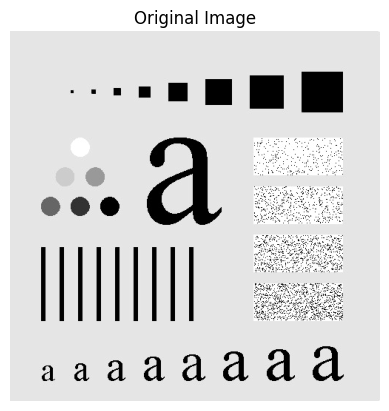

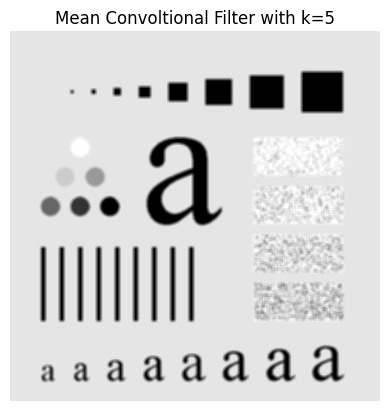

Time taken for mean filter: 0.0238 seconds


In [12]:
img1 = read_image("testPattern.jpg", cvtcolor="GRAY", cvtfloat=True)
mf, timing = meanFilter(img1, kernel_size=5, timing=True)

show_image(img1, cmap="gray", title="Original Image")
show_image(mf, cmap="gray", title="Mean Convoltional Filter with k=5")
print("Time taken for mean filter: {:.4f} seconds".format(timing))

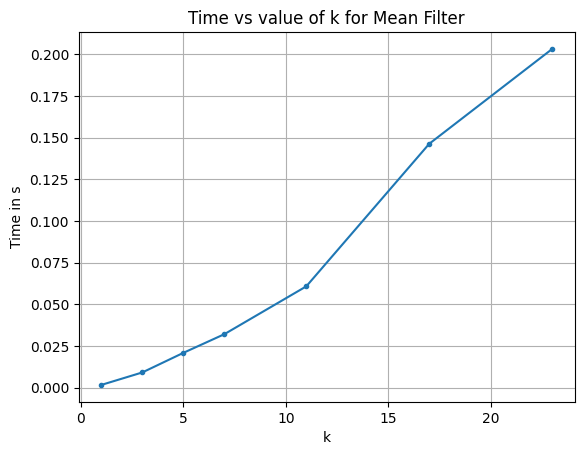

In [46]:
timings = list()
ks = [1,3,5,7,11,17,23]

for k in ks:
    _, timing = meanFilter(img1, kernel_size=k, timing=True)
    timings.append(timing)

plt.plot(ks, timings, marker=".")
plt.xlabel("k")
plt.ylabel("Time in s")
plt.title("Time vs value of k for Mean Filter")
plt.grid(True)
plt.show()

> **Impact on Time with different kernel size**

Larger kernel sizes mean more calculations are needed for each pixel in the output image. Specifically, the time complexity of a convolution operation is `O(k^2 * M * N)`, where:

`k` is the size of the kernel (both height and width).
`M` is the height of the input image.
`N` is the width of the input image.

Impact of kernel size on time complexity is quadratic. So, if you double the kernel size, you quadruple the time it takes to run the convolution operation.

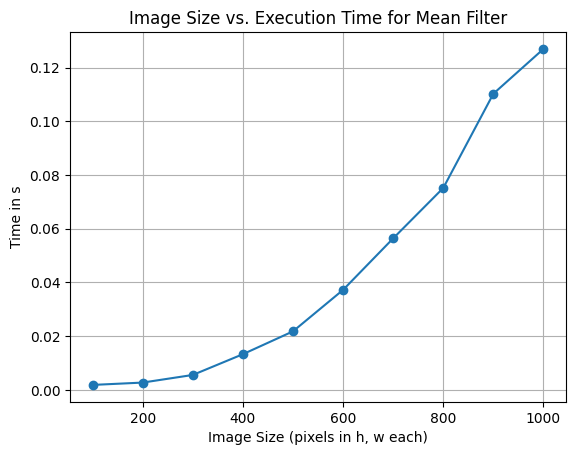

In [42]:
timings = list()
image_sizes = range(100, 1100, 100)

for size in image_sizes:
    random_image = np.random.rand(size, size)
    _, timing = meanFilter(random_image, kernel_size=5, timing=True)
    timings.append(timing)

plt.plot(image_sizes, timings, marker='o')
plt.title('Image Size vs. Execution Time for Mean Filter')
plt.xlabel('Image Size (pixels in h, w each)')
plt.ylabel('Time in s')
plt.grid(True)
plt.show()

> **Impact on Time with different Image size**

Larger image sizes mean more calculations are needed for each pixel in the output image. Specifically, the time complexity of a convolution operation is `O(k^2 * M * N)`, where:

`k` is the size of the kernel (both height and width).
`M` is the height of the input image.
`N` is the width of the input image.

The impact of image dimensions (h and w) on computation time is linear. Doubling the dimensions will approximately double the time taken for convolution.

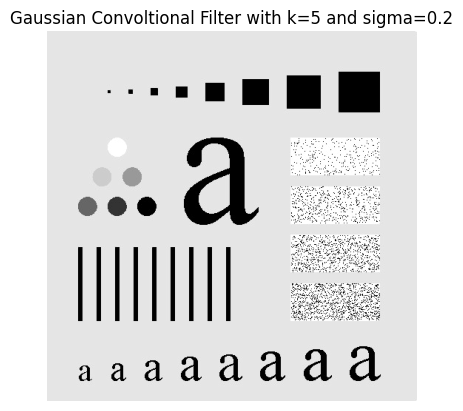

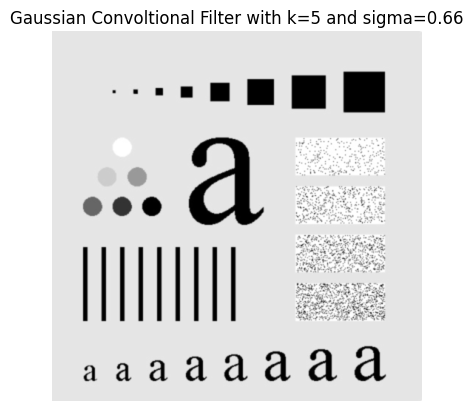

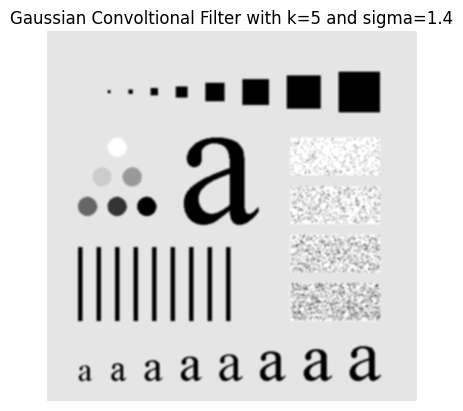

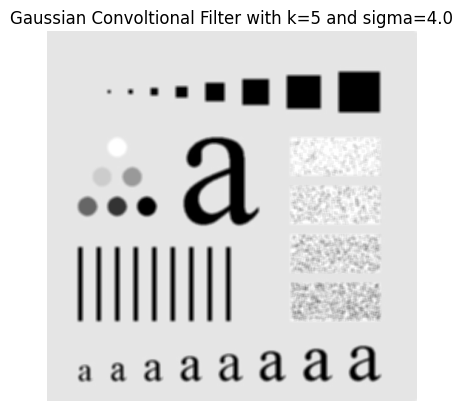

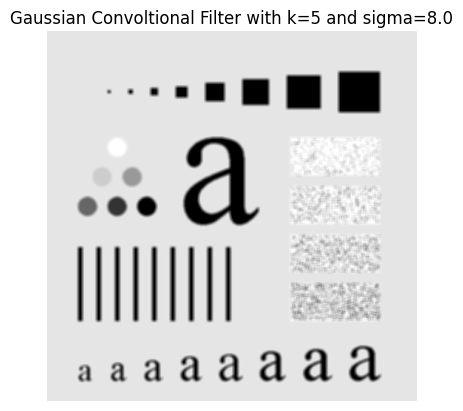

In [15]:
show_image(gaussianFilter(img1, kernel_size=5, sigma=0.2), cmap="gray", title="Gaussian Convoltional Filter with k=5 and sigma=0.2")
show_image(gaussianFilter(img1, kernel_size=5, sigma=0.66), cmap="gray", title="Gaussian Convoltional Filter with k=5 and sigma=0.66")
show_image(gaussianFilter(img1, kernel_size=5, sigma=1.4), cmap="gray", title="Gaussian Convoltional Filter with k=5 and sigma=1.4")
show_image(gaussianFilter(img1, kernel_size=5, sigma=4.0), cmap="gray", title="Gaussian Convoltional Filter with k=5 and sigma=4.0")
show_image(gaussianFilter(img1, kernel_size=5, sigma=8.0), cmap="gray", title="Gaussian Convoltional Filter with k=5 and sigma=8.0")

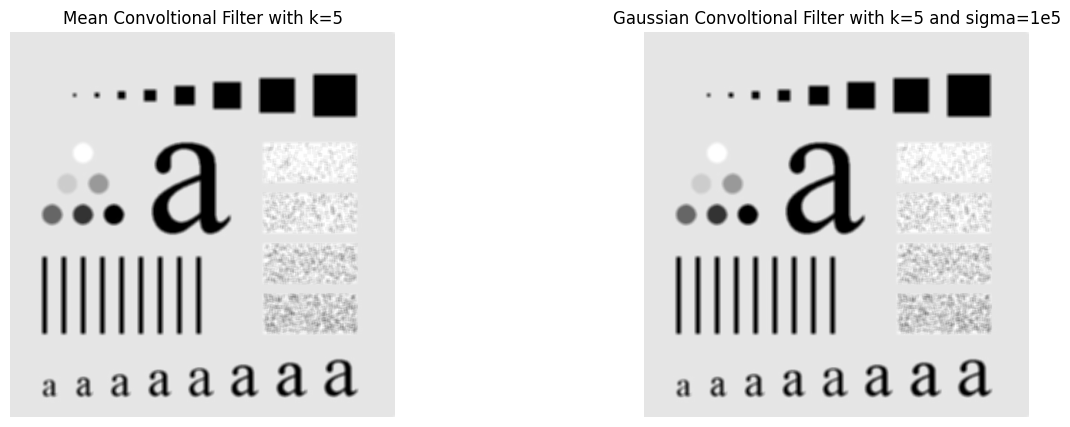

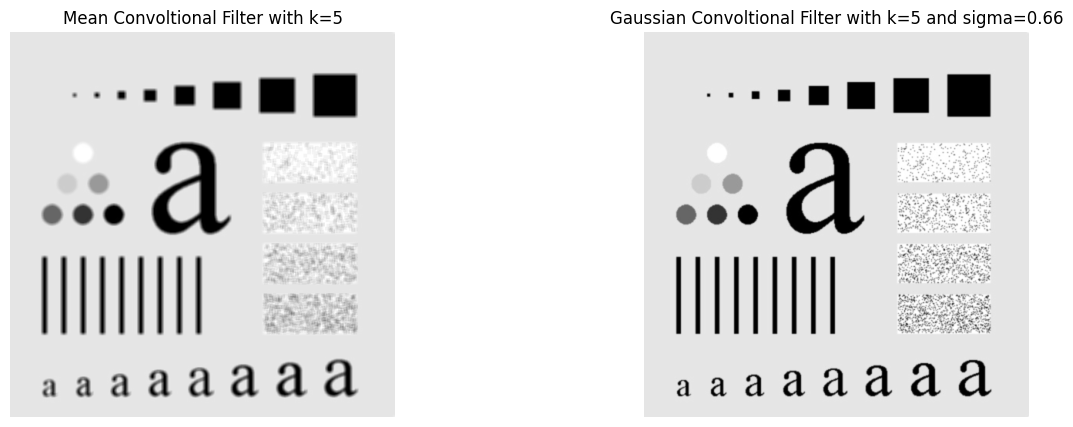

MSE between Mean Filter and Gaussian Filter with sigma=1e5: 0.0
MSE between Mean Filter and Gaussian Filter with sigma=0.66: 0.00396765163829477


In [16]:
mf = meanFilter(img1, kernel_size=5)
gf = gaussianFilter(img1, kernel_size=5, sigma=1e5)
gf1 = gaussianFilter(img1, kernel_size=5, sigma=0.66)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(mf, cmap="gray")
axs[0].set_title("Mean Convoltional Filter with k=5")
axs[0].axis('off')
axs[1].imshow(gf, cmap="gray")
axs[1].set_title("Gaussian Convoltional Filter with k=5 and sigma=1e5")
axs[1].axis('off')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(mf, cmap="gray")
axs[0].set_title("Mean Convoltional Filter with k=5")
axs[0].axis('off')
axs[1].imshow(gf1, cmap="gray")
axs[1].set_title("Gaussian Convoltional Filter with k=5 and sigma=0.66")
axs[1].axis('off')
plt.show()

mse1 = np.mean((mf - gf) ** 2)
mse2 = np.mean((mf - gf1) ** 2)

print("MSE between Mean Filter and Gaussian Filter with sigma=1e5: {}".format(mse1))
print("MSE between Mean Filter and Gaussian Filter with sigma=0.66: {}".format(mse2))

> Observations

As we can see from the above images, the image with Mean Filter looks more identical to the image with Gaussian Filter with very high sigma value. This behavior occurs because a very large sigma value in the Gaussian filter results in a very broad and flat Gaussian kernel, essentially approaching a uniform or mean filter.

This can also be checked quantitatively by calculating the mean squared error between the two images. The MSE between the Mean Filter and Gaussian Filter with sigma = 0.66 is of order of 0.003, but with sigma = 1e5, it is of order of almost 0, thus showing the high similarity between the images of mean filter and gaussian filter with high sigma value.

#### 2. Need for Speed

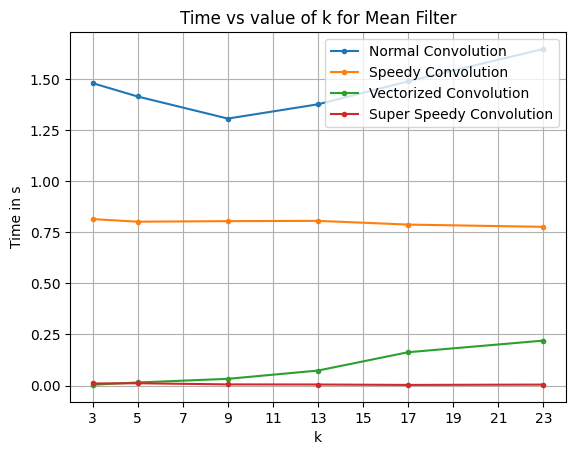

In [41]:
timings = list()
vectorizedTimings = list()
speedyTimings = list()
superSpeedyTimings = list()
ks = [3,5,9,13,17,23]

for k in ks:
    _, timing = meanFilter(img1, kernel_size=k, timing=True, vectorized=False)
    timings.append(timing)

    _, timing = meanFilter(img1, kernel_size=k, timing=True)
    vectorizedTimings.append(timing)

    _, timing = speedyMeanFilter(img1, kernel_size=k, timing=True)
    speedyTimings.append(timing)

    _, timing = superSpeedyMeanFilter(img1, kernel_size=k, timing=True)
    superSpeedyTimings.append(timing)

plt.plot(ks, timings, marker=".", label="Normal Convolution")
plt.plot(ks, speedyTimings, marker=".", label="Speedy Convolution")
plt.plot(ks, vectorizedTimings, marker=".", label="Vectorized Convolution")
plt.plot(ks, superSpeedyTimings, marker=".", label="Super Speedy Convolution")
plt.xlabel("k")
plt.ylabel("Time in s")
plt.title("Time vs value of k for Mean Filter")
plt.xticks(range(int(np.floor(min(ks))), int(np.ceil(max(ks))+1),2))
plt.grid(True)
plt.legend()
plt.show()

#### 3. Salt and Pepper

- `IMG2` -> Pepper Noise
- `IMG3` -> Salt Noise
- `IMG4` -> Salt and Pepper Noise

In [18]:
img2 = read_image("salt_noise.png", cvtcolor="GRAY", cvtfloat=True)
img3 = read_image("pepper_noise.png", cvtcolor="GRAY", cvtfloat=True)
img4 = read_image("salt_and_pepper_noise.png", cvtcolor="GRAY", cvtfloat=True)

In [19]:
corrected_img_2 = noise_removal(img2, "pepper")
corrected_img_3 = noise_removal(img3, "salt")
corrected_img_4 = noise_removal(img4, "salt_and_pepper")

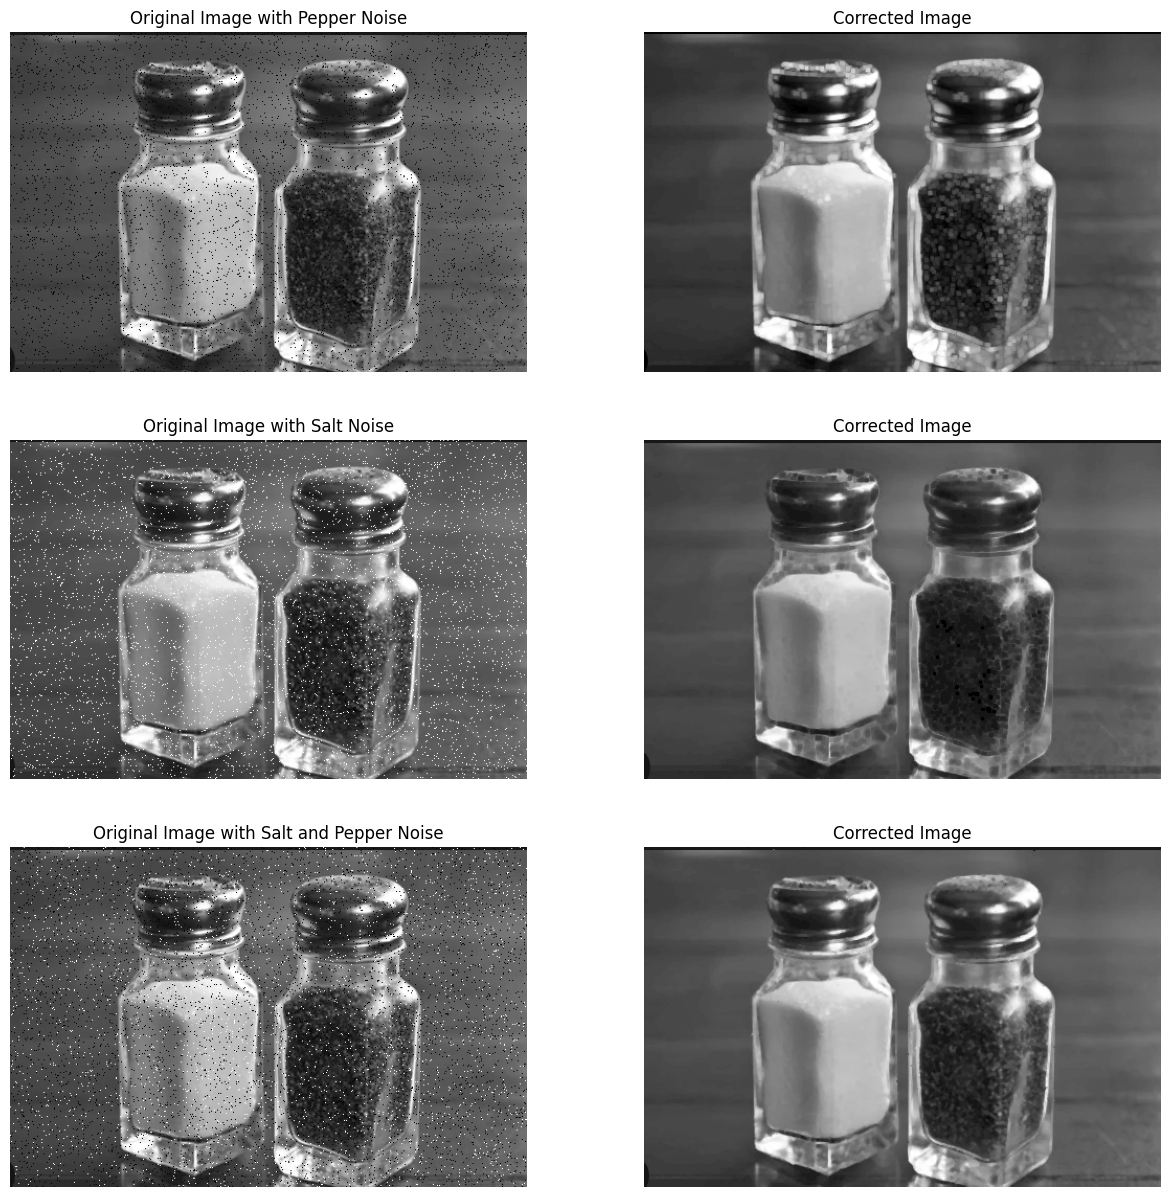

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs[0, 0].imshow(img2, cmap="gray")
axs[0, 0].axis('off')
axs[0, 0].set_title("Original Image with Pepper Noise")
axs[0, 1].imshow(corrected_img_2, cmap="gray")
axs[0, 1].axis('off')
axs[0, 1].set_title("Corrected Image")

axs[1, 0].imshow(img3, cmap="gray")
axs[1, 0].axis('off')
axs[1, 0].set_title("Original Image with Salt Noise")
axs[1, 1].imshow(corrected_img_3, cmap="gray")
axs[1, 1].axis('off')
axs[1, 1].set_title("Corrected Image")

axs[2, 0].imshow(img4, cmap="gray")
axs[2, 0].axis('off')
axs[2, 0].set_title("Original Image with Salt and Pepper Noise")
axs[2, 1].imshow(corrected_img_4, cmap="gray")
axs[2, 1].axis('off')
axs[2, 1].set_title("Corrected Image")

plt.show()

#### 4. Blurry? Don’t Worry

In [21]:
img5 = read_image("blurry_spiral.png", cvtcolor="GRAY", cvtfloat=True)

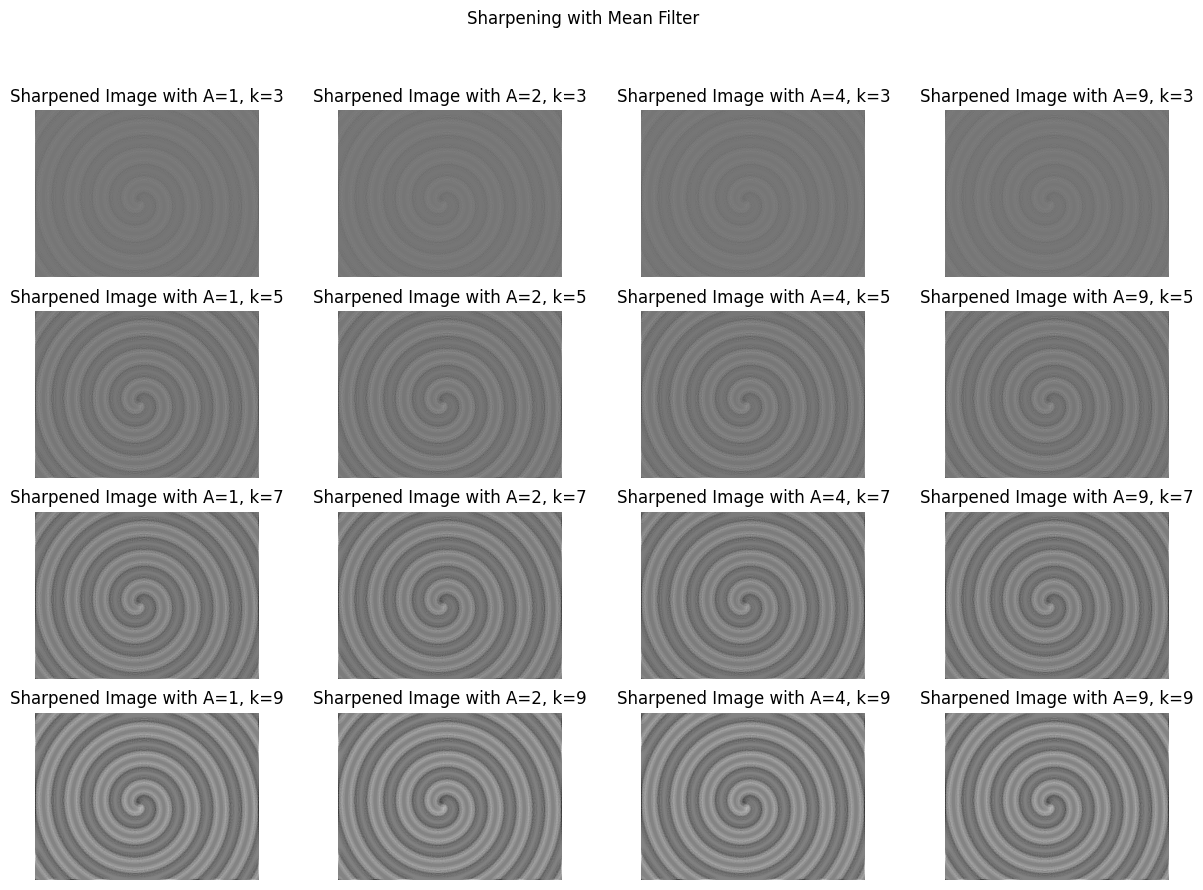

In [22]:
fig, axs = plt.subplots(4, 4, figsize=(15, 10))

for i, k in enumerate([3, 5, 7, 9]):
    for j, A in enumerate([1, 2, 4, 9]):    
        sharpened_img_5 = sharpen(img5, A=A, k=k)

        axs[i][j].imshow(sharpened_img_5, cmap="gray")
        axs[i][j].axis('off')
        axs[i][j].set_title("Sharpened Image with A={}, k={}".format(A,k))

fig.suptitle("Sharpening with Mean Filter")
plt.show()

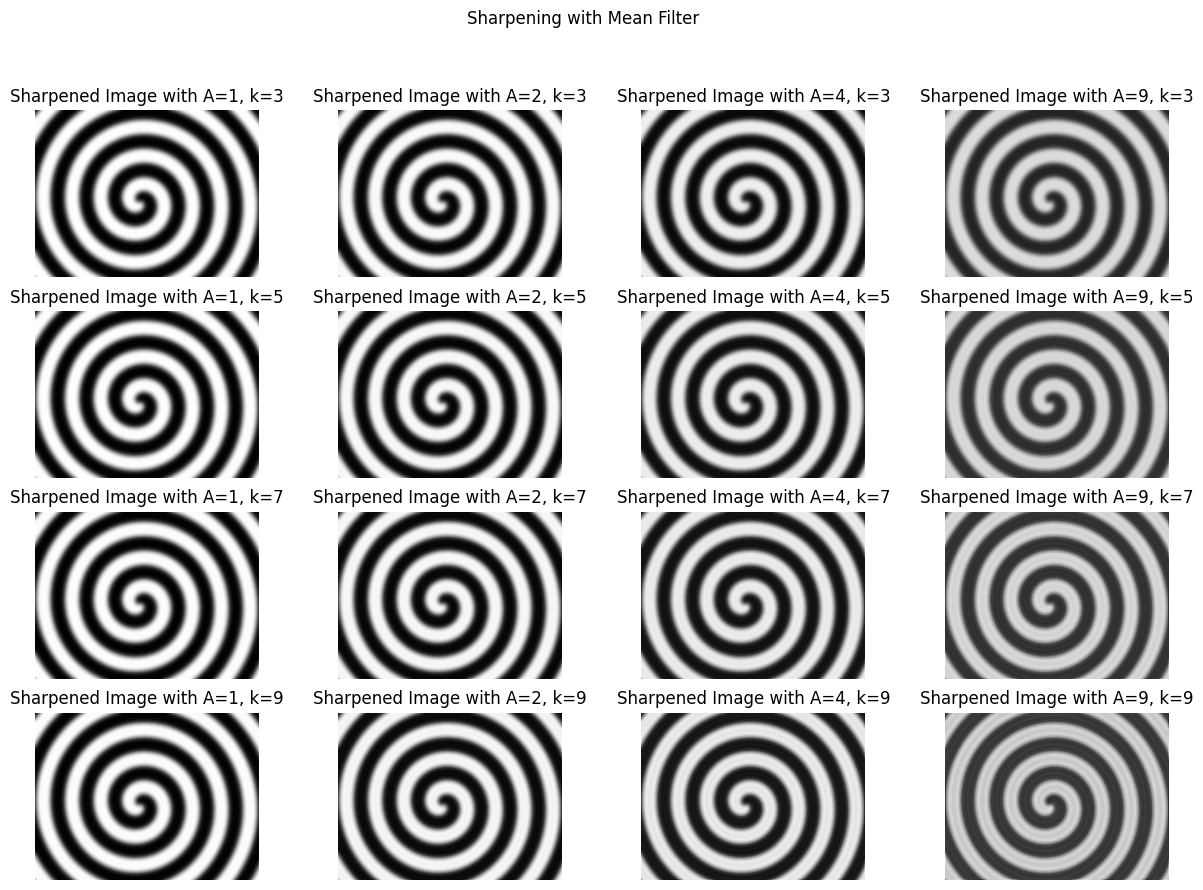

In [23]:
fig, axs = plt.subplots(4, 4, figsize=(15, 10))

for i, k in enumerate([3, 5, 7, 9]):
    for j, A in enumerate([1, 2, 4, 9]):    
        sharpened_img_5 = sharpen(img5, A=A, k=k, output="image")

        axs[i][j].imshow(sharpened_img_5, cmap="gray")
        axs[i][j].axis('off')
        axs[i][j].set_title("Sharpened Image with A={}, k={}".format(A,k))

fig.suptitle("Sharpening with Mean Filter")
plt.show()

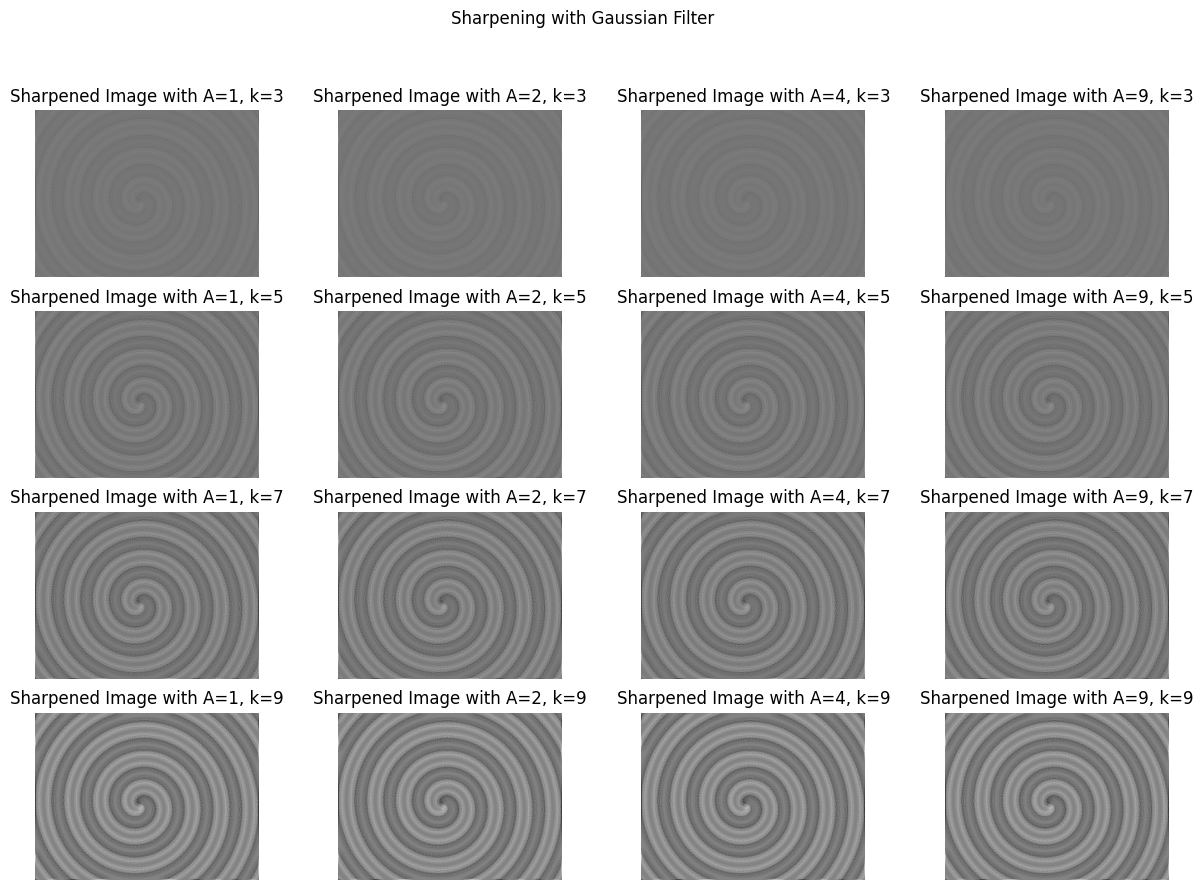

In [24]:
fig, axs = plt.subplots(4, 4, figsize=(15, 10))

for i, k in enumerate([3, 5, 7, 9]):
    for j, A in enumerate([1, 2, 4, 9]):    
        sharpened_img_5 = sharpen(img5, A=A, k=k, type="gaussian", sigma=10)

        axs[i][j].imshow(sharpened_img_5, cmap="gray")
        axs[i][j].axis('off')
        axs[i][j].set_title("Sharpened Image with A={}, k={}".format(A,k))

fig.suptitle("Sharpening with Gaussian Filter")
plt.show()

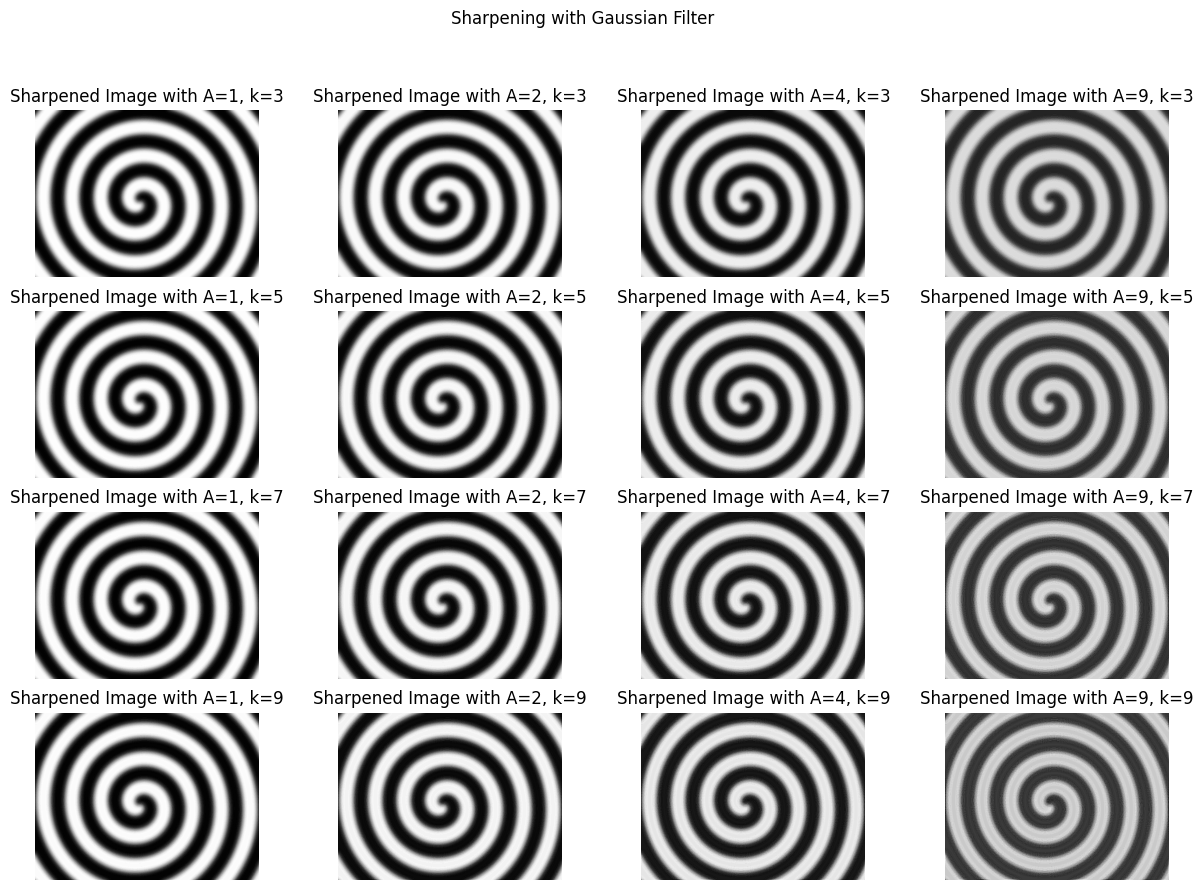

In [25]:
fig, axs = plt.subplots(4, 4, figsize=(15, 10))

for i, k in enumerate([3, 5, 7, 9]):
    for j, A in enumerate([1, 2, 4, 9]):    
        sharpened_img_5 = sharpen(img5, A=A, k=k, type="gaussian", sigma=10, output="image")

        axs[i][j].imshow(sharpened_img_5, cmap="gray")
        axs[i][j].axis('off')
        axs[i][j].set_title("Sharpened Image with A={}, k={}".format(A,k))

fig.suptitle("Sharpening with Gaussian Filter")
plt.show()

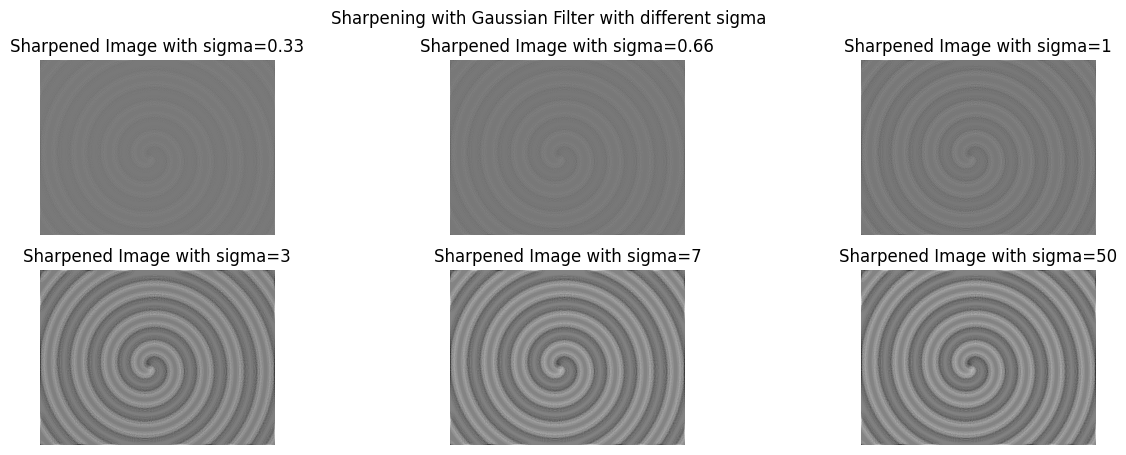

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i, sigma in enumerate([0.33, 0.66, 1, 3, 7, 50]):
    sharpened_img_5 = sharpen(img5, A=9, k=9, type="gaussian", sigma=sigma, output="filter")

    axs[i//3][i%3].imshow(sharpened_img_5, cmap="gray")
    axs[i//3][i%3].axis('off')
    axs[i//3][i%3].set_title("Sharpened Image with sigma={}".format(sigma))

fig.suptitle("Sharpening with Gaussian Filter with different sigma")
plt.show()

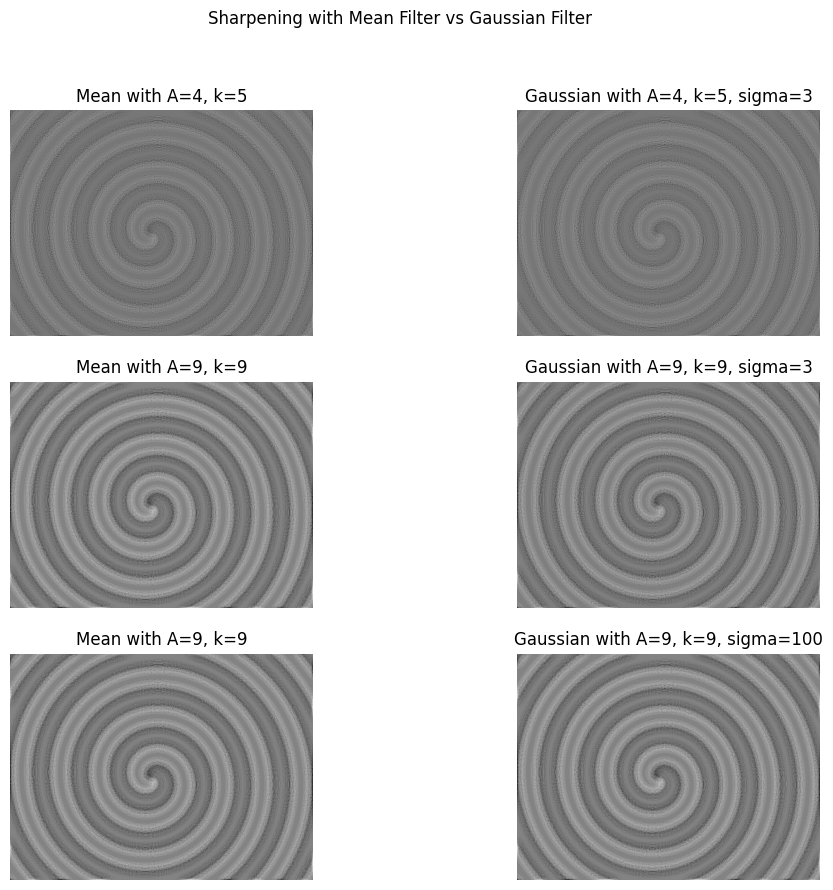

In [27]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

axs[0][0].imshow(sharpen(img5, A=4, k=5, type="mean", output="filter"), cmap="gray")
axs[0][0].axis('off')
axs[0][0].set_title("Mean with A=4, k=5")

axs[0][1].imshow(sharpen(img5, A=4, k=5, type="gaussian", sigma=3, output="filter"), cmap="gray")
axs[0][1].axis('off')
axs[0][1].set_title("Gaussian with A=4, k=5, sigma=3")

axs[1][0].imshow(sharpen(img5, A=9, k=9, type="mean", output="filter"), cmap="gray")
axs[1][0].axis('off')
axs[1][0].set_title("Mean with A=9, k=9")

axs[1][1].imshow(sharpen(img5, A=9, k=9, type="gaussian", sigma=3, output="filter"), cmap="gray")
axs[1][1].axis('off')
axs[1][1].set_title("Gaussian with A=9, k=9, sigma=3")

axs[2][0].imshow(sharpen(img5, A=9, k=9, type="mean", output="filter"), cmap="gray")
axs[2][0].axis('off')
axs[2][0].set_title("Mean with A=9, k=9")

axs[2][1].imshow(sharpen(img5, A=9, k=9, type="gaussian", sigma=100, output="filter"), cmap="gray")
axs[2][1].axis('off')
axs[2][1].set_title("Gaussian with A=9, k=9, sigma=100")

fig.suptitle("Sharpening with Mean Filter vs Gaussian Filter")
plt.show()

> Observations

As we can see from the above images, the image with Mean Filter looks more identical to the image with Gaussian Filter with very high sigma value. This behavior occurs because a very large sigma value in the Gaussian filter results in a very broad and flat Gaussian kernel, essentially approaching a uniform or mean filter.

Also, using the mean filter, we get stronger sharpening effects but with a potential for blocky artifacts and less preservation of fine details. On the other hand, using the Gaussian filter, we get smoother and more visually appealing results with better edge preservation and noise reduction.

#### 5. Counting Coins

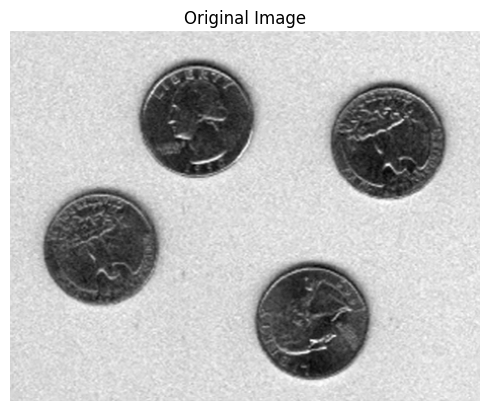

In [28]:
img6 = read_image("coins.PNG", cvtcolor="GRAY", cvtfloat=True)

show_image(img6, cmap="gray", title="Original Image")

In [29]:
prewitt_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
prewitt_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

In [30]:
prewitt_x_gradient = conv2D(img6, prewitt_x)
prewitt_y_gradient = conv2D(img6, prewitt_y)

sobel_x_gradient = conv2D(img6, sobel_x)
sobel_y_gradient = conv2D(img6, sobel_y)

laplacian_gradient = conv2D(img6, laplacian_kernel)
laplacian_magnitude = np.abs(laplacian_gradient)

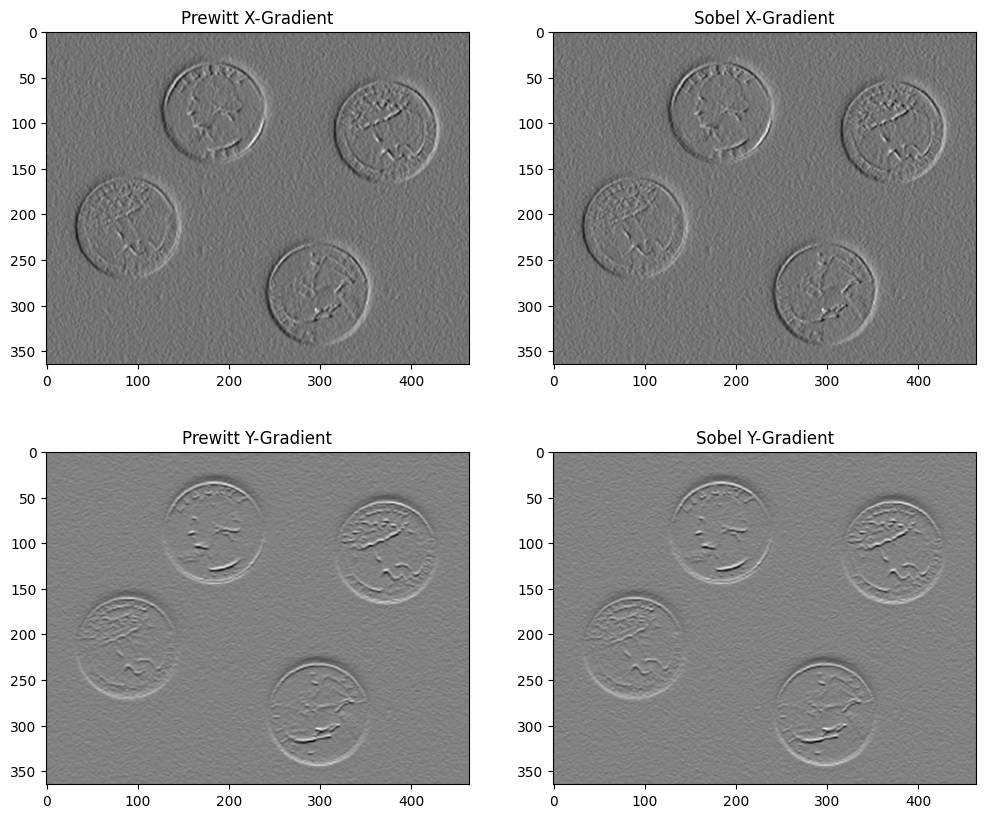

In [31]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.imshow(prewitt_x_gradient, cmap='gray')
plt.title('Prewitt X-Gradient')
plt.subplot(2, 2, 3)
plt.imshow(prewitt_y_gradient, cmap='gray')
plt.title('Prewitt Y-Gradient')
plt.subplot(2, 2, 2)
plt.imshow(sobel_x_gradient, cmap='gray')
plt.title('Sobel X-Gradient')
plt.subplot(2, 2, 4)
plt.imshow(sobel_y_gradient, cmap='gray')
plt.title('Sobel Y-Gradient')
plt.show()

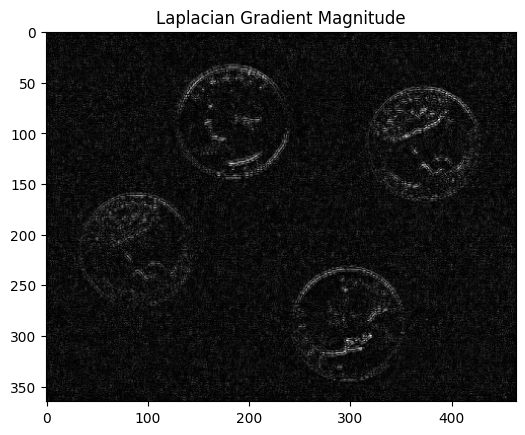

In [32]:
# Plot the Laplacian gradient magnitude
plt.imshow(laplacian_magnitude, cmap='gray')
plt.title('Laplacian Gradient Magnitude')
plt.show()

> Comment on the above

As we can see that the Sobel and Prewitt filters are sensitive to direction, whereas the Laplacian Filter is enhancing edges in all of the directions with a single application.

Also, we can see that the Prewitt filters kind of produce more sharper, and well-defined edges than the Sobel filters. Although in the given image, the results look very same, but the difference is at very micro level, and almost faintly visible.

#### 6. Hurry! Make it Blurry

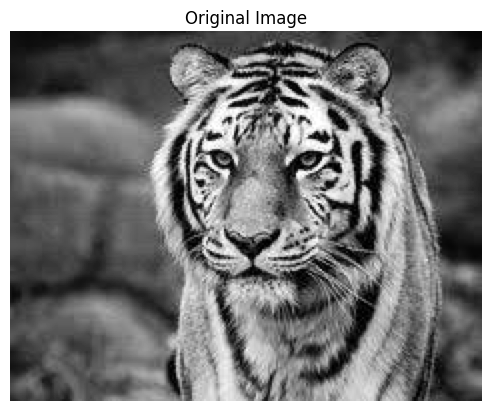

In [33]:
img7 = read_image("tiger.jpg", cvtcolor="GRAY", cvtfloat=True)

show_image(img7, cmap="gray", title="Original Image")

In [34]:
k_values = [3, 5]
sigma_s_values = [0.1, 10]
sigma_r_values = [0.1, 10]

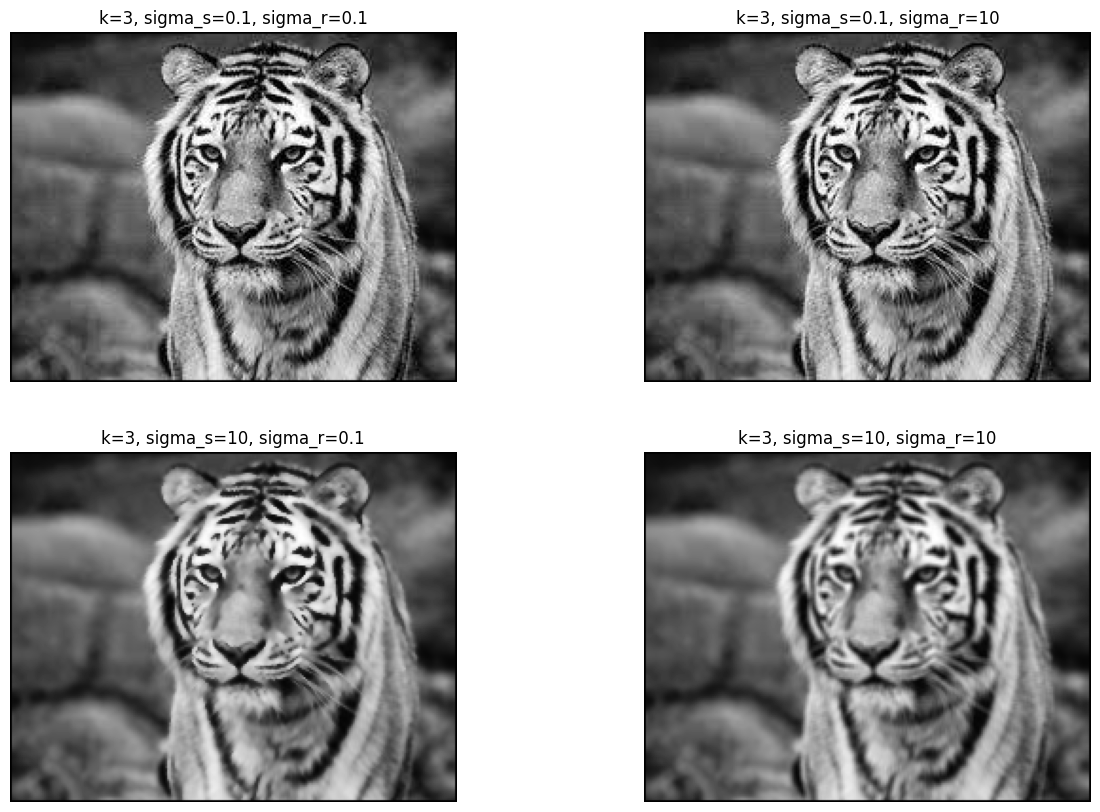

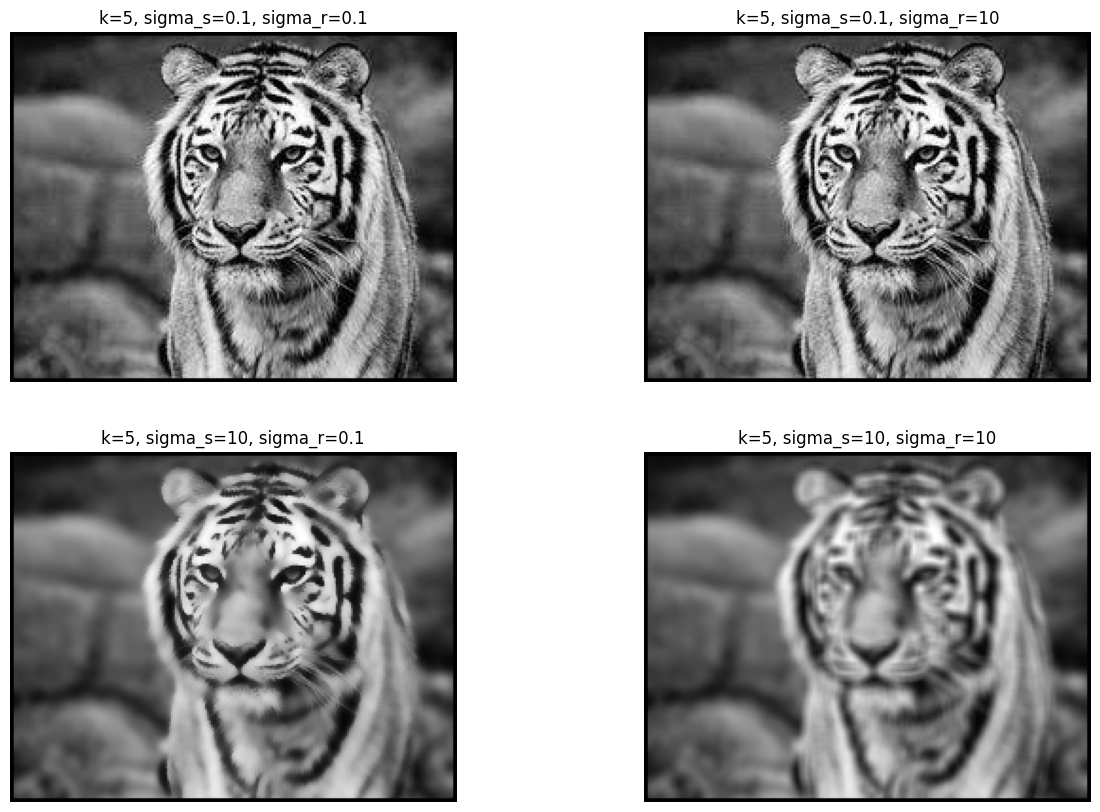

In [35]:
for k in k_values:
    fig, axs = plt.subplots(len(sigma_s_values), len(sigma_r_values), figsize=(15, 10))
    for i, sigma_s in enumerate(sigma_s_values):
        for j, sigma_r in enumerate(sigma_r_values):
            filtered_image = bilateralFilter(img7, k, sigma_s, sigma_r)

            axs[i, j].imshow(filtered_image, cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title('k={}, sigma_s={}, sigma_r={}'.format(k, sigma_s, sigma_r))

    plt.show()

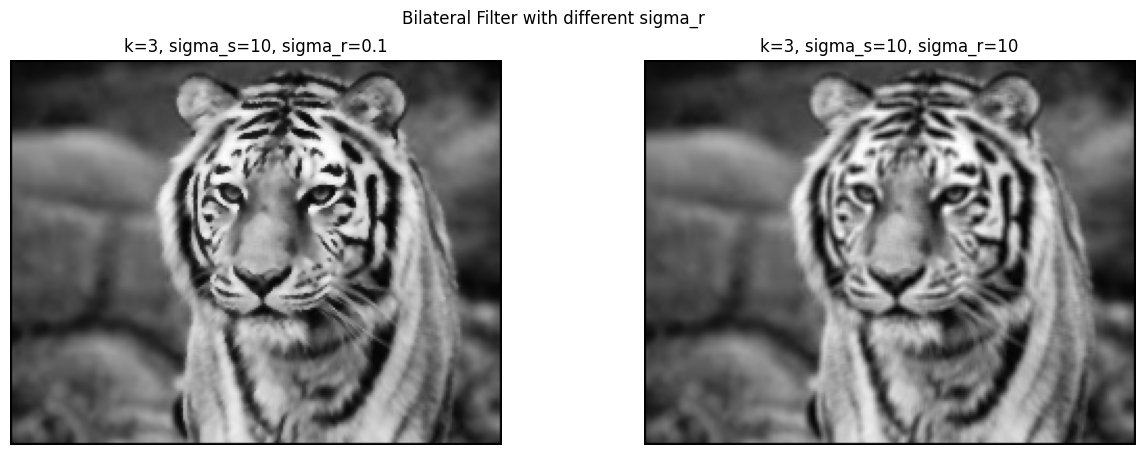

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

filtered_image = bilateralFilter(img7, k_values[0], sigma_s_values[1], sigma_r_values[0])
axs[0].imshow(filtered_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('k={}, sigma_s={}, sigma_r={}'.format(k_values[0], sigma_s_values[1], sigma_r_values[0]))

filtered_image = bilateralFilter(img7, k_values[0], sigma_s_values[1], sigma_r_values[1])
axs[1].imshow(filtered_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title('k={}, sigma_s={}, sigma_r={}'.format(k_values[0], sigma_s_values[1], sigma_r_values[1]))

fig.suptitle("Bilateral Filter with different sigma_r")
plt.show()

> Observations

As we can see from the above images, the low sigma_r value is preserving sharp edges and details while reducing noise, whereas the high sigma_r value is smoothing out the image and reducing noise, but at the cost of blurring the edges and details.

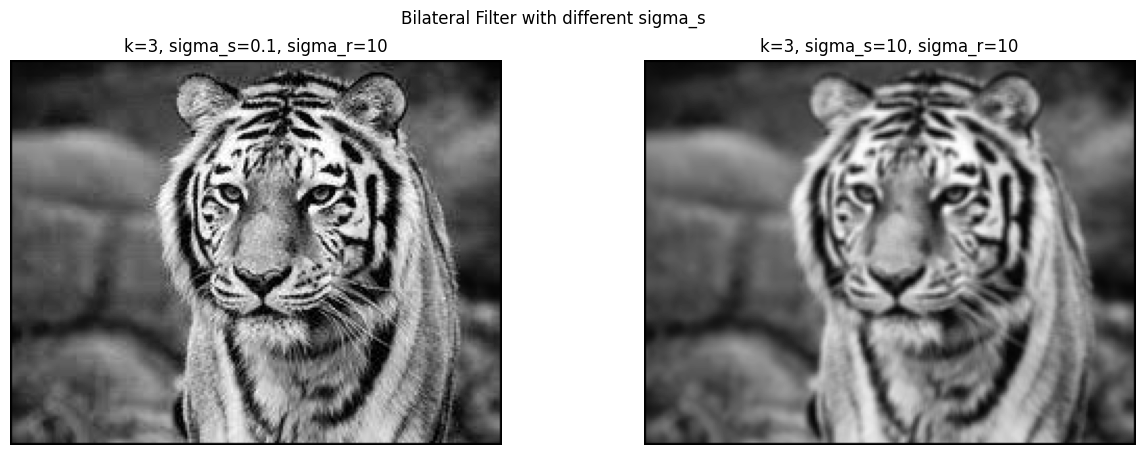

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

filtered_image = bilateralFilter(img7, k_values[0], sigma_s_values[0], sigma_r_values[1])
axs[0].imshow(filtered_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('k={}, sigma_s={}, sigma_r={}'.format(k_values[0], sigma_s_values[0], sigma_r_values[1]))

filtered_image = bilateralFilter(img7, k_values[0], sigma_s_values[1], sigma_r_values[1])
axs[1].imshow(filtered_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title('k={}, sigma_s={}, sigma_r={}'.format(k_values[0], sigma_s_values[1], sigma_r_values[1]))

fig.suptitle("Bilateral Filter with different sigma_s")
plt.show()

> Observations

As we can see from the above images, the low sigma_s value is able to preserve the edges and details, but is not able to reduce the noise, whereas the high sigma_s value is able to reduce the noise, but at the cost of blurring the edges and details.

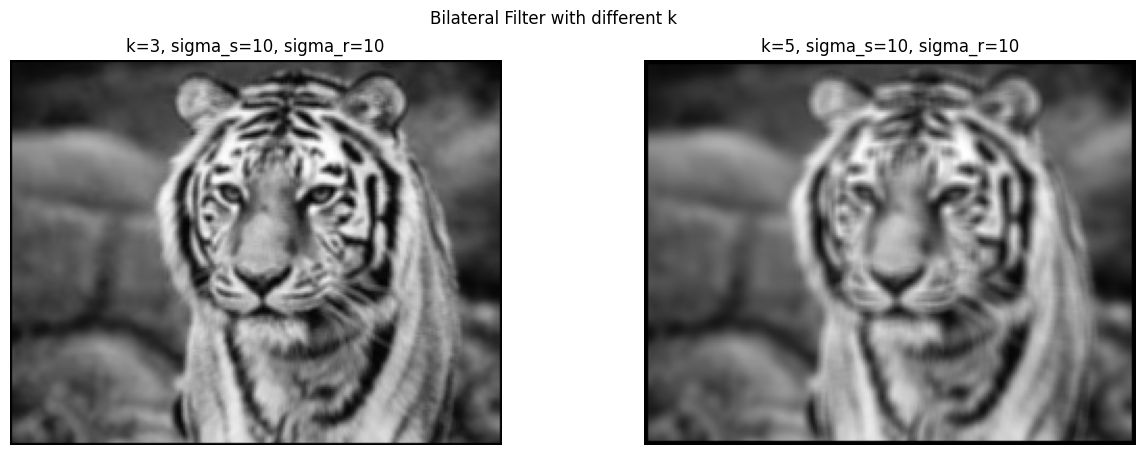

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

filtered_image = bilateralFilter(img7, k_values[0], sigma_s_values[1], sigma_r_values[1])
axs[0].imshow(filtered_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('k={}, sigma_s={}, sigma_r={}'.format(k_values[0], sigma_s_values[1], sigma_r_values[1]))

filtered_image = bilateralFilter(img7, k_values[1], sigma_s_values[1], sigma_r_values[1])
axs[1].imshow(filtered_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title('k={}, sigma_s={}, sigma_r={}'.format(k_values[1], sigma_s_values[1], sigma_r_values[1]))

fig.suptitle("Bilateral Filter with different k")
plt.show()

> Observations

As can be seen from the above images, the smaller kernel size is able to preserve the edges and details, but is not able to reduce the noise, whereas the larger kernel size is able to reduce the noise in regions with broader variations, but at the cost of blurring the edges and details.

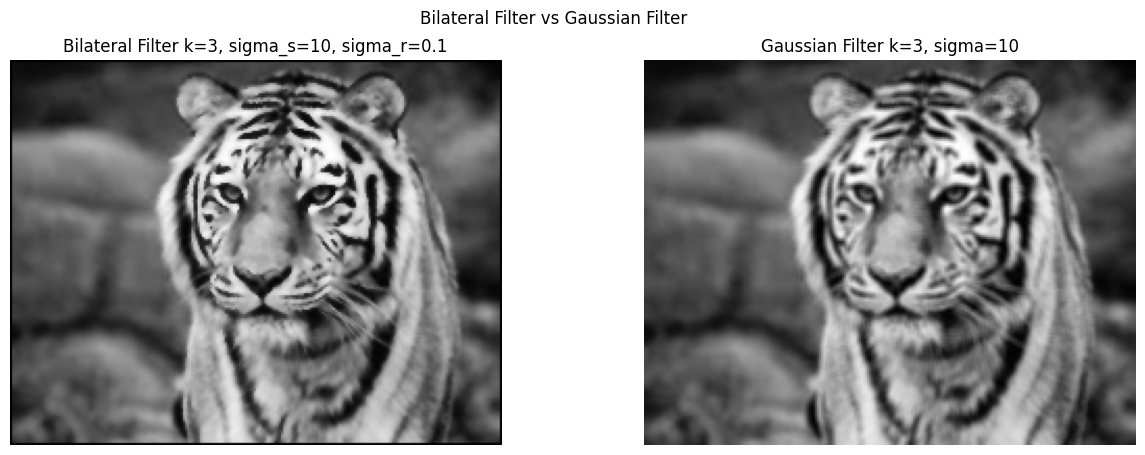

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

filtered_image = bilateralFilter(img7, k_values[0], sigma_s_values[1], sigma_r_values[0])
axs[0].imshow(filtered_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Bilateral Filter k={}, sigma_s={}, sigma_r={}'.format(k_values[0], sigma_s_values[1], sigma_r_values[0]))

filtered_image = gaussianFilter(img7, kernel_size=k_values[0], sigma=sigma_s_values[1])
axs[1].imshow(filtered_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Gaussian Filter k={}, sigma={}'.format(k_values[0], sigma_s_values[1]))

fig.suptitle("Bilateral Filter vs Gaussian Filter")
plt.show()

> Observations

As we can see from the above images, the bilateral filtering is good for edge preservations, keeping sharp edges while removing noises. While in the gaussian filtering, the noises are dissolved, but at the cost of smoother edges.